# PROBLEM STATEMENT

Data assimilation are numerical methods used in geosciences to mix the information of observations (noted as $y$) and a dynamical model (noted as $\mathcal{M}$) in order to estimate the true/hidden state of the system (noted as $x$) at every time step $t$. Usually, they are related following a nonlinear state-space model:
\begin{align}
  x(t) & = \mathcal{M}\left(x(t-\text{d}t)\right) + \eta(t)\\
  y(t) & = \mathcal{H}\left(x(t)\right) + \epsilon(t)
\end{align}
with $\eta$ and $\epsilon$ independants zero-mean Gaussian noises with covariances $Q$ and $R$, respectively representing the model forecast error and the error of observation. Specification and tuning of these errors are important issues in data assimilation. Here, we evaluate the performance of different methods to estimate offline the covariance matrices $Q$ and $R$ using the Extended Kalman Smoother:
- Expectation-Maximization algorithm (noted EM-EKS, see Dreano et al. 2017)
- Lag-Innovation statistics (noted LI-EKS, see Berry and Sauer 2013)

We apply EM-EKS and LI-EKS methods on the 40-dimensional Lorenz-96 dynamical model with $\text{d}t=0.05$. We assume that we observe all the components of the state at every time steps. We performe 2 experiments: estimation of only diagonal terms and estimation of full Q and R matrices. 

# IMPORT MODULES

Here, we import the different Python libraries and modules. Concerning the dynamical models, we provide two different implementations: a slow procedure in Python and a fast procedure in Fortran. In order to use the Fortran version, you need to compile the f90 files in the "models" folder ("l63_for.f90" and "l96_for.f90") using the command "f2py". You also need to download the "tqdm" library to display the progress bar (available at http://github.com/tqdm/).

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# save simulation results
import dill
import pickle

# save figures
from scipy.misc import imsave

# plot text on figures
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

# L63 and L96 models using fortran (fast)
import models.l96f as mdl_l96

# L63 and L96 models using python (slow)
from models.L96 import l96_predict, l96_f, l96_jac

# data assimilation routines
#from algos.EM_EnKS import EnKS, EM_EnKS
from algos.EM_EKS import _EKF, _EKS, EKS, EM_EKS
from algos.LI_EKS import LI_EKF, LI_EKS
#from algos.CI_EKS import CI_EKF, CI_EKS
#from algos.BI_EKF import BI_EKF
from algos.utils import climat_background, RMSE, gen_truth, gen_obs ### METTRE COV. PROB. ###

Populating the interactive namespace from numpy and matplotlib


/home/ptandeo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## EM-EKS vs LI-EKS (offline) for diagonal Q and R ##

In this experiment, we assume that Q and R covariances are diagonal such as $Q=0.1 I$ and $R=2 I$. First, we generate the data on $500$ L-96 times.

In [ ]:
# random number generator
prng = numpy.random.RandomState(1)

# dynamical model
Nx = 40 # dimension of the state
dt = .05 # integration time
F = 8 # physical parameter
#f = lambda x: l96_predict(x,dt,F) # python version (slow)
fmdl=mdl_l96.M(dtcy=dt, force=F, nx=Nx);f = lambda x: fmdl.integ(x) # fortran version (fast)
jacF = lambda x: l96_jac(x, dt) # python version (slow)

# observation operator
No = 40 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = eye(Nx)

# size of the sequence
T = 10000 ### IMPORTANT
time = range(T+1)*array([dt])

# generate state
Q_true = eye(Nx) * .1
X0_true = array(zeros(Nx))
X_true = gen_truth(f, X0_true, T+50, Q_true, prng)

# generate observations
dt_obs = 1 ### IMPORTANT
R_true = eye(No) * 2
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
X_true = X_true[:,50:T+50+1]
Yo = Yo[:,50:T+50+1]

# plot state and observations (sample of 20 Lorenz-96 times)
[X,Y]=meshgrid(range(Nx),time)
subplot(1,2,1);
pcolor(X[0:399,:], Y[0:399,:], X_true[:,0:399].T, cmap='jet')
xlim([0,Nx-1]);clim([-10,10]);
xlabel('Lorenz-96 variables', size=20)
ylabel('Lorenz-96 times', size=20)
title('True x', size=30)
subplot(1,2,2);
pcolor(X[0:399,:], Y[0:399,:], ma.masked_where(isnan(Yo[:,0:399].T),Yo[:,0:399].T), cmap='jet');
xlim([0,Nx-1]);clim([-10,10]);
xlabel('Lorenz-96 variables', size=20)
ylabel('Lorenz-96 times', size=20)
title('Observations y', size=30)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/x_y_L96_diagonal.png', bbox_inches='tight')

Then, we compute the likelihood and RMSE using the true Q and R parameters.

In [ ]:
# background state
xb, B = climat_background(X_true)

# parameters
params = { 'observations'                 : Yo,
           'background_state'             : xb,
           'background_covariance'        : B,
           'model_noise_covariance'       : Q_true,
           'observation_noise_covariance' : R_true,
           'model_dynamics'               : f,
           'model_jacobian'               : jacF,
           'observation_operator'         : h,
           'observation_jacobian'         : jacH,
           'state_size'                   : Nx,
           'observation_size'             : No,
           'temporal_window_size'         : T,
           'true_state'                   : X_true,
           'inflation_factor'             : 1
          }

# function
res_EKS = EKS(params)

# extract outputs
loglik_true = res_EKS['loglikelihood']
RMSE_true = res_EKS['RMSE']

We apply the EM-EKS with $Q = I$ and $R = I$ as initial conditions.

In [ ]:
# initial counditions and number of iterations
N_iter = 100
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full', # Q and R are full
           #'model_noise_covariance_matrix_template'   : eye(Nx,Nx), # Q is constant diagonal
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True, ### IMPORTANT
           'inflation_factor'                         : 1}

# function
res_EM_EKS = EM_EKS(params)

# store simulation results
filename = 'res_EM_EKS.pkl'
dill.dump(res_EM_EKS, open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'wb'))

We use LI-EKS with the same initial conditions.

In [ ]:
# initial counditions and number of iterations
N_iter = 100
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# loop on tau parameter for temporal smoothing
tab_tau = [20000, 35000, 50000]
for tau in tab_tau:

    # parameters
    params = { 'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : f,
               'model_jacobian'                           : jacF,
               'observation_operator'                     : h,
               'observation_jacobian'                     : jacH,
               'observations'                             : Yo,
               'nb_iterations'                            : N_iter,
               'true_state'                               : X_true,
               'state_size'                               : Nx,
               'observation_size'                         : No,
               'temporal_window_size'                     : T,
               'model_noise_covariance_structure'         : 'full', # Q and R are full
               'inflation_factor'                         : 1,
               'adaptive_parameter'                       : tau ### IMPORTANT
             }

    # function
    res_LI_EKS = LI_EKS(params)

    # store simulation results
    filename = 'res_LI_EKS_' + str(tau) + '.pkl'
    dill.dump(res_LI_EKS, open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'wb'))

Finaly, we plot and compare the 2 offline methods EM-EKS and LI-EKS for the estimation of constant $Q$ and $R$ matrices.

In [ ]:
##########################################################
# load simulation results
filename = 'res_EM_EKS.pkl'
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'rb') as in_strm:
    res_EM_EKS = dill.load(in_strm)

# extract outputs
Q_EM_EKS = res_EM_EKS['EM_model_noise_covariance']
R_EM_EKS = res_EM_EKS['EM_observation_noise_covariance']
loglik_EM_EKS=res_EM_EKS['loglikelihood']
RMSE_EM_EKS=res_EM_EKS['RMSE']
##########################################################

# loop on tau parameter for temporal smoothing (LI_EKS)
tab_tau = [20000, 35000, 50000]
i = 0
for tau in tab_tau:

    ##########################################################
    # load simulation results
    filename = 'res_LI_EKS_' + str(tau) + '.pkl'
    with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'rb') as in_strm:
        res_LI_EKS = dill.load(in_strm)

    # extract outputs
    Q_LI_EKS = res_LI_EKS['LI_model_noise_covariance']
    R_LI_EKS = res_LI_EKS['LI_observation_noise_covariance']
    loglik_LI_EKS = res_LI_EKS['loglikelihood']
    RMSE_LI_EKS = res_LI_EKS['RMSE']
    ##########################################################
    
    # plot trace of Q
    plt.subplot(2,2,1)
    line1,=plt.plot(trace(Q_EM_EKS)/Nx,'b')
    line2,=plt.plot(trace(Q_LI_EKS)/Nx,'g')
    line3,=plt.plot((0,N_iter),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k')
    plt.xlabel('Iterations', fontsize=20)
    plt.ylabel('Q estimates', fontsize=20)
    ylim([0,1])
    #plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True Q'], fontsize=20)

    # plot trace of R
    plt.subplot(2,2,2)
    line1,=plt.plot(trace(R_EM_EKS)/No,'b')
    line2,=plt.plot(trace(R_LI_EKS)/No,'g')
    line3,=plt.plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
    plt.xlabel('Iterations', fontsize=20)
    plt.ylabel('R estimates', fontsize=20)
    ylim([1,2.2])
    #plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True R'], fontsize=20)

    # plot log-likelihood
    plt.subplot(2,2,3)
    line1,=plt.plot(loglik_EM_EKS,'b')
    line2,=plt.plot(loglik_LI_EKS,'g')
    line3,=plt.plot((0,N_iter),(loglik_true,loglik_true),'--k')
    plt.xlabel('Iterations', fontsize=20)
    plt.ylabel('Log-likelihood', fontsize=20)
    #plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True log-lik'], fontsize=20)

    # plot Root Mean Square Error
    plt.subplot(2,2,4)
    line1,=plt.plot(RMSE_EM_EKS,'b')
    line2,=plt.plot(RMSE_LI_EKS,'g')
    line3,=plt.plot((0,N_iter),(RMSE_true,RMSE_true),'--k')
    plt.xlabel('Iterations', fontsize=20)
    plt.ylabel('RMSE', fontsize=20)
    #plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True RMSE'], fontsize=20)

    i +=1
    
# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/' + 'L96_Q_R_offline.png', bbox_inches='tight')

## EM-EKS vs LI-EKS (offline) for full Q and R ##

In this experiment, we assume that Q and R covariances are full such as XXX (same expirement as in XXX). First, we generate the data on $500$ L-96 times.

Text(0.5,1,'Observations y')

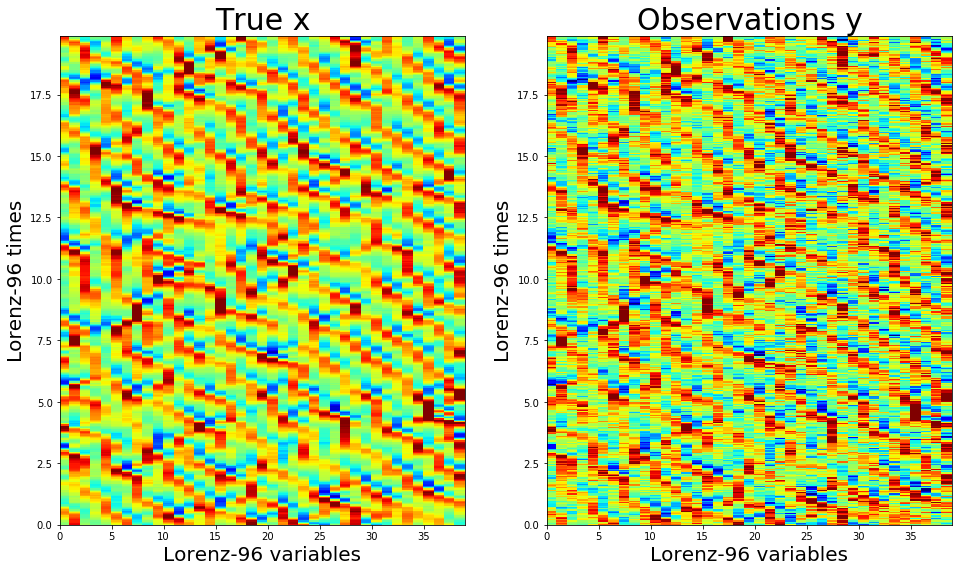

In [2]:
# random number generator
prng = numpy.random.RandomState(1)

# dynamical model
Nx = 40 # dimension of the state
dt = .05 # integration time
F = 8 # physical parameter
#f = lambda x: l96_predict(x,dt,F) # python version (slow)
fmdl=mdl_l96.M(dtcy=dt, force=F, nx=Nx);f = lambda x: fmdl.integ(x) # fortran version (fast)
jacF = lambda x: l96_jac(x, dt) # python version (slow)

# observation operator
No = 40 # dimension of the observations
h = lambda x: x
jacH = lambda x: np.eye(Nx)
H = eye(Nx)

# size of the sequence
T = 10000 ### IMPORTANT
time = range(T+1)*array([dt])

# generate state
spatial_cov_Q = lambda dist: 0.1*exp(-dist/5)
Q_true=spatial_cov_Q(0)*eye(Nx)
for i_dist in range(1,20):
    Q_true += diag(spatial_cov_Q(i_dist)*ones(Nx-i_dist),i_dist) + diag(spatial_cov_Q(i_dist)*ones(Nx-i_dist),-i_dist)
    Q_true += diag(spatial_cov_Q(i_dist)*ones(i_dist),Nx-i_dist) + diag(spatial_cov_Q(i_dist)*ones(i_dist),Nx-i_dist).T
i_dist = 20
Q_true += diag(spatial_cov_Q(i_dist)*ones(Nx-i_dist),i_dist) + diag(spatial_cov_Q(i_dist)*ones(Nx-i_dist),-i_dist)
X0_true = array(zeros(Nx))
X_true = gen_truth(f, X0_true, T+50, Q_true, prng)

# generate observations
dt_obs = 1 ### IMPORTANT
R_true = block([[2*eye(int(No/2)), zeros((int(No/2),int(No/2)))],
                [zeros((int(No/2),int(No/2))), 4*eye(int(No/2))]])
Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

# remove first part of the sequence (time to converge to the attractor)
X_true = X_true[:,50:T+50+1]
Yo = Yo[:,50:T+50+1]

# plot state and observations (sample of 20 Lorenz-96 times)
[X,Y]=meshgrid(range(Nx),time)
subplot(1,2,1);
pcolor(X[0:399,:], Y[0:399,:], X_true[:,0:399].T, cmap='jet')
xlim([0,Nx-1]);clim([-10,10]);
xlabel('Lorenz-96 variables', size=20)
ylabel('Lorenz-96 times', size=20)
title('True x', size=30)
subplot(1,2,2);
pcolor(X[0:399,:], Y[0:399,:], ma.masked_where(isnan(Yo[:,0:399].T),Yo[:,0:399].T), cmap='jet');
xlim([0,Nx-1]);clim([-10,10]);
xlabel('Lorenz-96 variables', size=20)
ylabel('Lorenz-96 times', size=20)
title('Observations y', size=30)

# save figure
#savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/x_y_L96_full.png', bbox_inches='tight')

Then, we compute the likelihood and RMSE using the true Q and R parameters.

In [3]:
# background state
xb, B = climat_background(X_true)

# parameters
params = { 'observations'                 : Yo,
           'background_state'             : xb,
           'background_covariance'        : B,
           'model_noise_covariance'       : Q_true,
           'observation_noise_covariance' : R_true,
           'model_dynamics'               : f,
           'model_jacobian'               : jacF,
           'observation_operator'         : h,
           'observation_jacobian'         : jacH,
           'state_size'                   : Nx,
           'observation_size'             : No,
           'temporal_window_size'         : T,
           'true_state'                   : X_true,
           'inflation_factor'             : 1
          }

# function
res_EKS = EKS(params)

# extract outputs
loglik_true = res_EKS['loglikelihood']
RMSE_true = res_EKS['RMSE']

We apply the EM-EKS with $Q = I$ and $R = I$ as initial conditions.

In [4]:
# initial counditions and number of iterations
N_iter = 200
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# parameters
params = { 'initial_background_state'                 : xb,
           'initial_background_covariance'            : B,
           'initial_model_noise_covariance'           : Q_init,
           'initial_observation_noise_covariance'     : R_init,
           'model_dynamics'                           : f,
           'model_jacobian'                           : jacF,
           'observation_operator'                     : h,
           'observation_jacobian'                     : jacH,
           'observations'                             : Yo,
           'nb_EM_iterations'                         : N_iter,
           'true_state'                               : X_true,
           'state_size'                               : Nx,
           'observation_size'                         : No,
           'temporal_window_size'                     : T,
           'model_noise_covariance_structure'         : 'full', # Q and R are full
           #'model_noise_covariance_matrix_template'   : eye(Nx,Nx), # Q is constant diagonal
           'is_model_noise_covariance_estimated'      : True,
           'is_observation_noise_covariance_estimated': True,
           'is_background_estimated'                  : True, ### IMPORTANT
           'inflation_factor'                         : 1}

# function
res_EM_EKS = EM_EKS(params)

# store simulation results
filename = 'res_EM_EKS_full.pkl'
dill.dump(res_EM_EKS, open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'wb'))

'''
chosen_cmap = plt.get_cmap('gray_r')
Q_EM_EKS_schur = res_EM_EKS['EM_model_noise_covariance']
RMSE_EM_EKS_schur = res_EM_EKS['RMSE']
'''

100%|██████████| 200/200 [45:41<00:00, 13.71s/it]


"\nchosen_cmap = plt.get_cmap('gray_r')\nQ_EM_EKS_schur = res_EM_EKS['EM_model_noise_covariance']\nRMSE_EM_EKS_schur = res_EM_EKS['RMSE']\n"

We use LI-EKS with the same initial conditions.

In [5]:
# initial counditions and number of iterations
N_iter = 200 # 100
Q_init = eye(Nx) # identity matrix for initial Q
R_init = eye(No) # identity matrix for initial R

# loop on tau parameter for temporal smoothing
tab_tau = [100000]# [20000, 35000, 50000]
for tau in tab_tau:

    # parameters
    params = { 'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : f,
               'model_jacobian'                           : jacF,
               'observation_operator'                     : h,
               'observation_jacobian'                     : jacH,
               'observations'                             : Yo,
               'nb_iterations'                            : N_iter,
               'true_state'                               : X_true,
               'state_size'                               : Nx,
               'observation_size'                         : No,
               'temporal_window_size'                     : T,
               'model_noise_covariance_structure'         : 'full', # Q and R are full
               'inflation_factor'                         : 1,
               'adaptive_parameter'                       : tau ### IMPORTANT
             }

    # function
    res_LI_EKS = LI_EKS(params)

    # store simulation results
    filename = 'res_LI_EKS_' + str(tau) + '_full.pkl'
    dill.dump(res_LI_EKS, open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'wb'))

  2%|▏         | 3/200 [01:33<1:42:45, 31.30s/it]

KeyboardInterrupt: 

Finaly, we plot and compare the 2 offline methods EM-EKS and LI-EKS for the estimation of constant $Q$ and $R$ matrices.

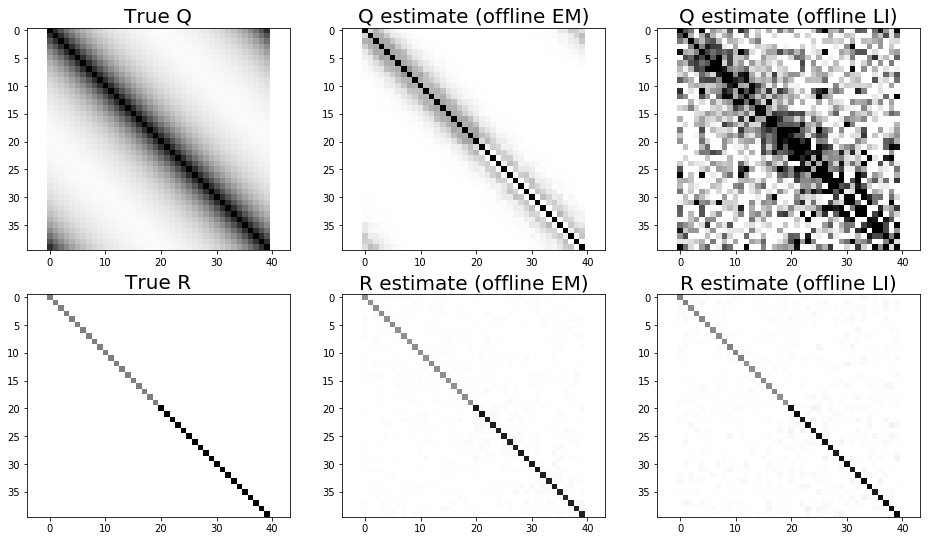

In [6]:
##########################################################
# load simulation results
filename = 'res_EM_EKS_full.pkl'
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'rb') as in_strm:
    res_EM_EKS = dill.load(in_strm)

# extract outputs
Q_EM_EKS = res_EM_EKS['EM_model_noise_covariance']
R_EM_EKS = res_EM_EKS['EM_observation_noise_covariance']
loglik_EM_EKS=res_EM_EKS['loglikelihood']
RMSE_EM_EKS=res_EM_EKS['RMSE']
##########################################################

# loop on tau parameter for temporal smoothing (LI_EKS)
tab_tau = [100000]# [20000, 35000, 50000]
i = 0
for tau in tab_tau:

    ##########################################################
    # load simulation results
    filename = 'res_LI_EKS_' + str(tau) + '_full.pkl'
    with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'rb') as in_strm:
        res_LI_EKS = dill.load(in_strm)

    # extract outputs
    Q_LI_EKS = res_LI_EKS['LI_model_noise_covariance']
    R_LI_EKS = res_LI_EKS['LI_observation_noise_covariance']
    loglik_LI_EKS = res_LI_EKS['loglikelihood']
    RMSE_LI_EKS = res_LI_EKS['RMSE']
    ##########################################################
    
    chosen_cmap = plt.get_cmap('gray_r')
    
    # plot true Q
    plt.subplot(2,3,1)
    plt.imshow(Q_true, cmap=chosen_cmap)
    plt.clim([0,0.1])
    plt.axis('equal')
    plt.title('True Q', fontsize=20)
    
    # plot Q (EM-EKS)
    plt.subplot(2,3,2)
    plt.imshow(Q_EM_EKS[:,:,-1], cmap=chosen_cmap)#, interpolation='gaussian')
    plt.clim([0,0.1])
    plt.axis('equal')
    plt.title('Q estimate (offline EM)', fontsize=20)
    
    # plot Q (LI-EKS)
    plt.subplot(2,3,3)
    plt.imshow(Q_LI_EKS[:,:,-1], cmap=chosen_cmap)#, interpolation='gaussian')
    plt.clim([0,0.1])

    plt.axis('equal')
    plt.title('Q estimate (offline LI)', fontsize=20)
    
    # plot true R
    plt.subplot(2,3,4)
    plt.imshow(R_true, cmap=chosen_cmap)
    plt.clim([0,4])
    plt.axis('equal')
    plt.title('True R', fontsize=20)
    
    # plot R (EM-EKS)
    plt.subplot(2,3,5)
    plt.imshow(R_EM_EKS[:,:,-1], cmap=chosen_cmap)#, interpolation='gaussian')
    plt.clim([0,4])
    plt.axis('equal')
    plt.title('R estimate (offline EM)', fontsize=20)
    
    # plot R (LI-EKS)
    plt.subplot(2,3,6)
    plt.imshow(R_LI_EKS[:,:,-1], cmap=chosen_cmap)#, interpolation='gaussian')    
    plt.clim([0,4])
    plt.axis('equal')
    plt.title('R estimate (offline LI)', fontsize=20)
    
    i +=1
    
# save figure
#savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/L96_Q_R_offline_full.png', bbox_inches='tight')

## TMP ##

Text(0,0.5,'Coverage probability (%)')

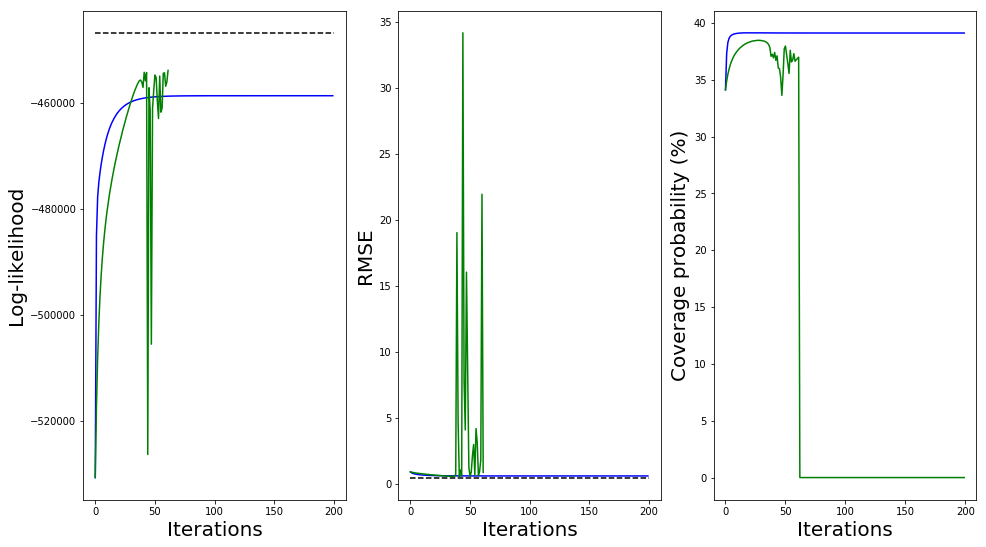

In [12]:
# extract outputs
cov_prob_EM_EKS=res_EM_EKS['cov_prob']
cov_prob_LI_EKS=res_LI_EKS['cov_prob']

### plot log-likelihood
plt.subplot(1,3,1)
line1,=plt.plot(loglik_EM_EKS,'b')
line2,=plt.plot(loglik_LI_EKS,'g')
line3,=plt.plot((0,N_iter),(loglik_true,loglik_true),'--k')
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Log-likelihood', fontsize=20)
#plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True log-lik'], fontsize=20)

# plot Root Mean Square Error
plt.subplot(1,3,2)
line1,=plt.plot(RMSE_EM_EKS,'b')
line2,=plt.plot(RMSE_LI_EKS,'g')
line3,=plt.plot((0,N_iter),(RMSE_true,RMSE_true),'--k')
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
#plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True RMSE'], fontsize=20)

# plot coverage probability
plt.subplot(1,3,3)
line1,=plt.plot(cov_prob_EM_EKS,'b')
line2,=plt.plot(cov_prob_LI_EKS,'g')
#line3,=plt.plot((0,N_iter),(cov_prob_true*100,cov_prob_true*100),'--k')
#plt.ylim([90,100])
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('Coverage probability (%)', fontsize=20)
#plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True RMSE'], fontsize=20)

# plot Root Mean Square Error
#plt.subplot(1,3,2)
#line1,=plt.plot(RMSE_EM_EKS,'b')
#line2,=plt.plot(RMSE_LI_EKS,'g')
#line3,=plt.plot((0,N_iter),(RMSE_true,RMSE_true),'--k')
#plt.xlabel('Iterations', fontsize=20)
#plt.ylabel('RMSE', fontsize=20)
#plt.legend([line1, line2, line3], ['EM-EKS', 'LI-EKS', 'True RMSE'], fontsize=20)

# save figure
#savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/L96_Q_R_offline_full_lik_RMSE_cov_prob.png', bbox_inches='tight')

In [ ]:
from algos.utils import gaspari_cohn
gaspari_cohn_matrix_Q = np.eye(40)
L = 10
for i_dist in range(1,40):
    gaspari_cohn_matrix_Q += np.diag(gaspari_cohn(i_dist/L)*np.ones(Nx-i_dist),i_dist) + np.diag(gaspari_cohn(i_dist/L)*np.ones(Nx-i_dist),-i_dist)
    gaspari_cohn_matrix_Q += np.diag(gaspari_cohn(i_dist/L)*np.ones(i_dist),Nx-i_dist) + np.diag(gaspari_cohn(i_dist/L)*np.ones(i_dist),Nx-i_dist).T

chosen_cmap = plt.get_cmap('gray_r')
subplot(2,2,1)
pcolor(Q_EM_EKS[:,:,-1], cmap = chosen_cmap)
colorbar()
clim([0,0.1])
axis('equal')
subplot(2,2,2)
pcolor(np.multiply(gaspari_cohn_matrix_Q,Q_EM_EKS[:,:,-1]), cmap = chosen_cmap)
colorbar()
clim([0,0.1])
axis('equal')
subplot(2,2,3)
pcolor(gaspari_cohn_matrix_Q, cmap = chosen_cmap)
colorbar()
clim([0,1])
axis('equal')

In [ ]:
subplot(2,2,1)
imshow(Q_EM_EKS_schur[:,:,-1], cmap=chosen_cmap)
clim([0,0.1])
axis('equal')
title('Q estimates (Schur)')
colorbar()
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/' + filename, 'rb') as in_strm:
    res_EM_EKS = dill.load(in_strm)
Q_EM_EKS = res_EM_EKS['EM_model_noise_covariance']
subplot(2,2,2)
imshow(Q_EM_EKS[:,:,-1], cmap=chosen_cmap)
clim([0,0.1])
axis('equal')
title('Q estimates (classic)')
colorbar()
subplot(2,2,3)
imshow(Q_true, cmap=chosen_cmap)
clim([0,0.1])
axis('equal')
title('Q true')
colorbar()
subplot(2,2,4)
imshow(Q_EM_EKS_schur[:,:,-1] - Q_EM_EKS[:,:,-1], cmap=chosen_cmap)
#clim([0,0.1])
axis('equal')
title('Q Schur - Q classic')
colorbar()